# KAN Papers

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RamtinMoslemi/KAN-Papers/blob/main/KAN_Papers.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/RamtinMoslemi/KAN-Papers/main/KAN_Papers.ipynb)

In [1]:
import re
import requests
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from matplotlib import pyplot as plt

# Extracting from arXiv

In [2]:
# @title Get papers from arXiv

month_converter = {"01": "January", "02": "February", "03": "March",
                   "04": "April", "05": "May", "06": "June",
                   "07": "July", "08": "August", "09": "September",
                   "10": "October", "11": "November", "12": "December"}


def get_page_papers(soup):
    page_papers = []

    # Find all paper entries
    paper_entries = soup.find_all('li', {'class': 'arxiv-result'})

    for entry in paper_entries:
        # Extract paper title
        title_tag = entry.find('p', {'class': 'title is-5 mathjax'})
        title = title_tag.text.strip() if title_tag else 'No Title Found'

        # Extract abstract link
        link_tag = entry.find('a', href=True)
        abstract_link = link_tag['href'] if link_tag else 'No Link Found'

        # Extract year and month from the link
        match = re.search(r'(\d{2})(\d{2})\.\d*', abstract_link)
        if match:
            year, month = str(20) + match.group(1), month_converter[match.group(2)]
        else:
            year, month = 'Unknown', 'Unknown'

        # Extract abstract text
        abstract_tag = entry.find('span', {'class': 'abstract-full has-text-grey-dark mathjax'})
        abstract = abstract_tag.text.replace('Abstract:', '').strip() if abstract_tag else "Abstract not found."
        if abstract.endswith('         △ Less'):
            abstract = abstract[:-len('         △ Less')]
        elif abstract.endswith(' △ Less'):
            abstract = abstract[:-len(' △ Less')]

        # Extract author names
        authors_tag = entry.find('p', {'class': 'authors'})
        author_names = []
        if authors_tag:
            author_tags = authors_tag.find_all('a')
            author_names = [author.text.strip() for author in author_tags]
        authors = ', '.join(author_names)

        page_papers.append({'Title': title, 'Abstract': abstract, 'Link': abstract_link, 'Year': year, 'Month': month, 'Authors': authors})
    return page_papers


def extract_paper_info(search_url='https://arxiv.org/search/advanced?advanced=&terms-0-operator=AND&terms-0-term=Kolmogorov-Arnold+Network&terms-0-field=all&classification-physics_archives=all&classification-include_cross_list=include&date-year=&date-filter_by=date_range&date-from_date=2024-04&date-to_date=&date-date_type=submitted_date_first&abstracts=show&size=200&order=-announced_date_first', size=200):
    papers = []
    while True:
        # Send a GET request to the search URL
        response = requests.get(search_url + f'&start={len(papers)}')
        soup = BeautifulSoup(response.content, 'html.parser')
        # Add paper from this page
        papers += get_page_papers(soup)
        # Stop on final page (must be fixed later)
        if len(papers) % size != 0:
            break
    return reversed(papers)

In [3]:
papers = extract_paper_info()
df = pd.DataFrame(papers)
df.to_csv('kan_papers.csv', index=False)

# Plots

In [4]:
df = pd.read_csv('kan_papers.csv')
df

,Title,Abstract,Link,Year,Month,Authors
0,KAN: Kolmogorov-Arnold Networks,Inspired by the Kolmogorov-Arnold representati...,https://arxiv.org/abs/2404.19756,2024,April,"Ziming Liu, Yixuan Wang, Sachin Vaidya, Fabian..."
1,Biology-inspired joint distribution neurons ba...,Biological neural networks seem qualitatively ...,https://arxiv.org/abs/2405.05097,2024,May,Jarek Duda
2,Kolmogorov-Arnold Networks are Radial Basis Fu...,This short paper is a fast proof-of-concept th...,https://arxiv.org/abs/2405.06721,2024,May,Ziyao Li
3,Chebyshev Polynomial-Based Kolmogorov-Arnold N...,Accurate approximation of complex nonlinear fu...,https://arxiv.org/abs/2405.07200,2024,May,"Sidharth SS, Keerthana AR, Gokul R, Anas KP"
4,TKAN: Temporal Kolmogorov-Arnold Networks,Recurrent Neural Networks (RNNs) have revoluti...,https://arxiv.org/abs/2405.07344,2024,May,"Remi Genet, Hugo Inzirillo"
...,...,...,...,...,...,...
204,Beyond Tree Models: A Hybrid Model of KAN and ...,Tabular data plays a critical role in real-wor...,https://arxiv.org/abs/2412.02097,2024,December,"Mingming Zhang, Jiahao Hu, Pengfei Shi, Ningta..."
205,Enhanced Photovoltaic Power Forecasting: An iT...,Accurate photovoltaic (PV) power forecasting i...,https://arxiv.org/abs/2412.02302,2024,December,"Guang Wu, Yun Wang, Qian Zhou, Ziyang Zhang"
206,CIKAN: Constraint Informed Kolmogorov-Arnold N...,The paper considers a Constrained-Informed Neu...,https://arxiv.org/abs/2412.03710,2024,December,"Taehyeun Kim, Anouck Girard, Ilya Kolmanovsky"
207,You KAN Do It in a Single Shot: Plug-and-Play ...,The use of Plug-and-Play (PnP) methods has bec...,https://arxiv.org/abs/2412.06204,2024,December,"Yanqi Cheng, Carola-Bibiane Schönlieb, Angelic..."


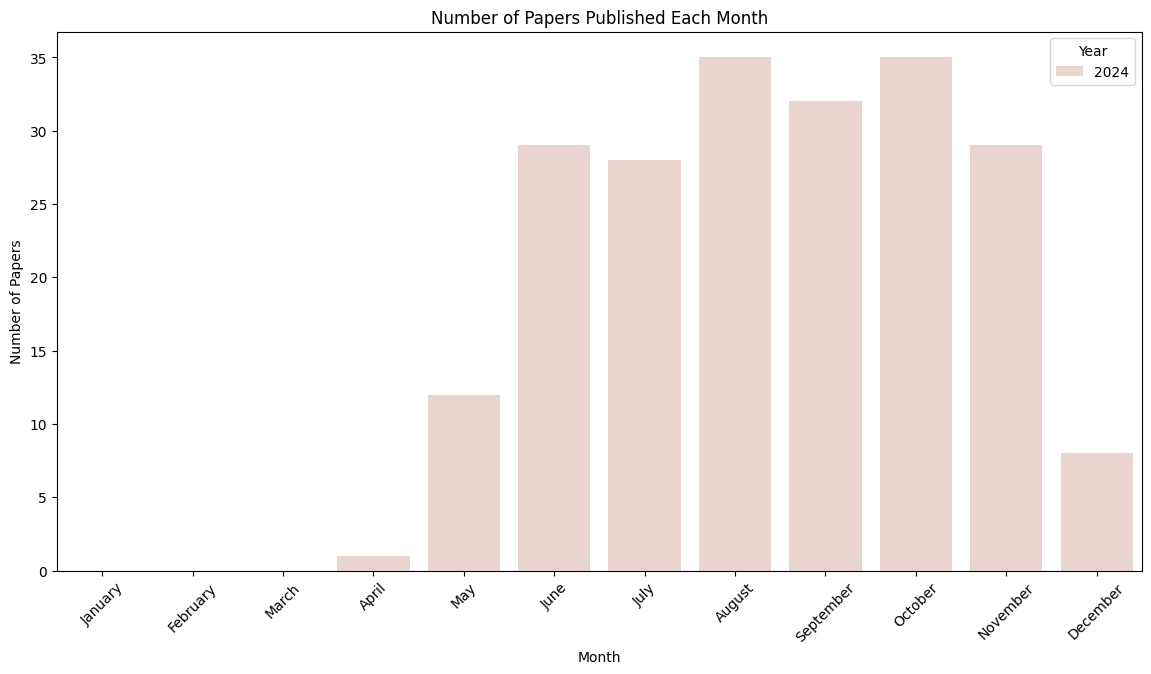

In [5]:
# Convert 'Month' to a categorical type with the correct order
df['Month'] = pd.Categorical(df['Month'], categories=[
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"],
    ordered=True)

# Group by Year and Month and count the number of papers
monthly_counts = df.groupby(['Year', 'Month'], observed=False).size().reset_index(name='Counts')

# Create the plot
plt.figure(figsize=(14, 7))

sns.barplot(data=monthly_counts, x='Month', y='Counts', hue='Year')

plt.title('Number of Papers Published Each Month')
plt.xlabel('Month')
plt.ylabel('Number of Papers')
plt.legend(title='Year')
plt.xticks(rotation=45)
plt.savefig('paper_by_month.svg')
plt.show()

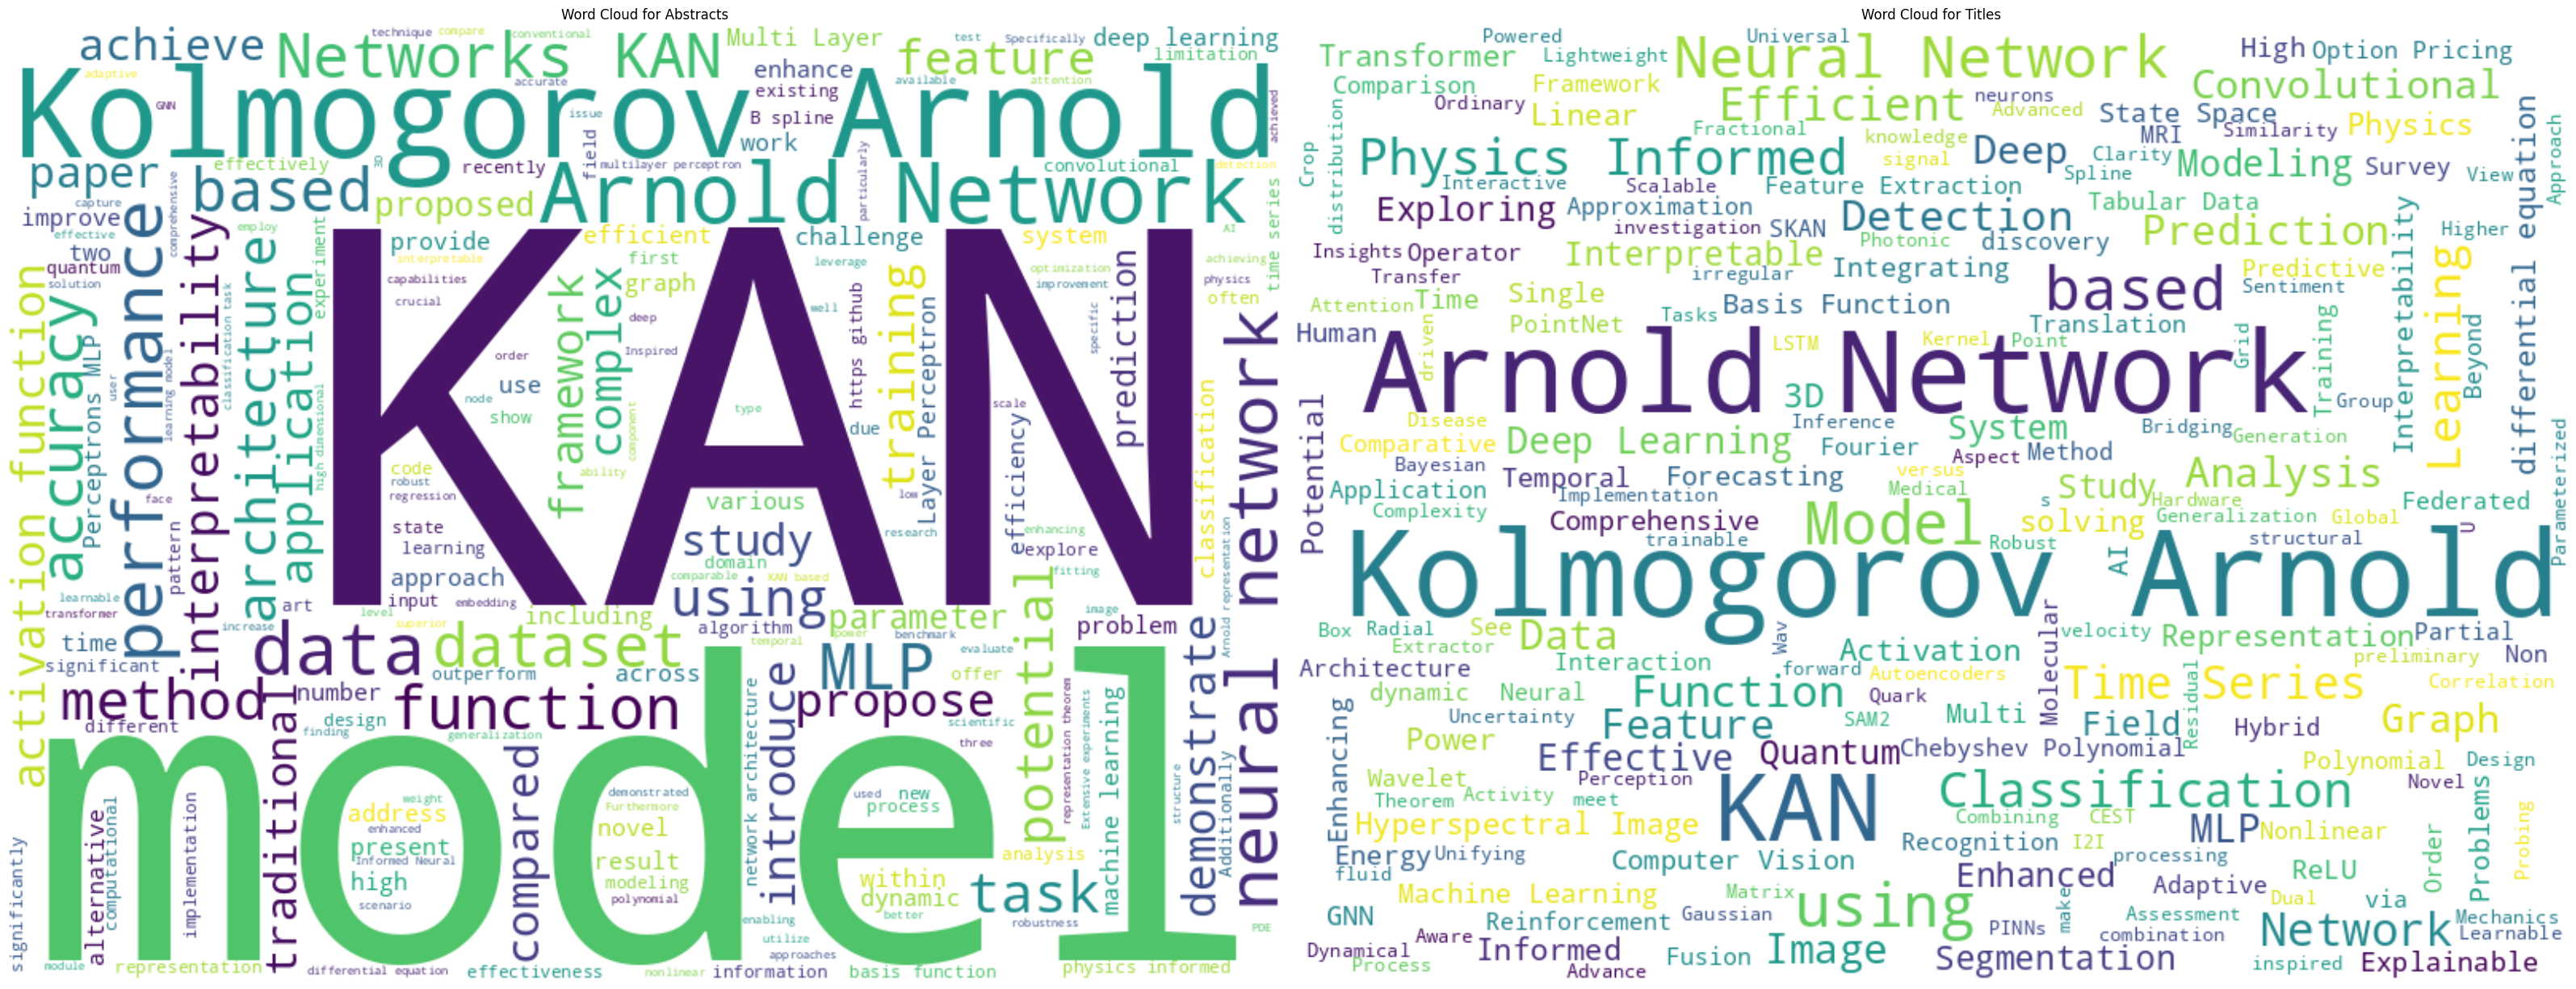

In [6]:
# Generate word cloud for abstracts
abstract_text = " ".join(df['Abstract'].dropna().tolist())
wordcloud_abstract = WordCloud(width=800, height=600, background_color='white').generate(abstract_text)

# Generate word cloud for titles
title_text = " ".join(df['Title'].dropna().tolist())
wordcloud_title = WordCloud(width=800, height=600, background_color='white').generate(title_text)

# Plot the word clouds
plt.figure(figsize=(32, 13))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_abstract, interpolation='bilinear')
plt.title('Word Cloud for Abstracts')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_title, interpolation='bilinear')
plt.title('Word Cloud for Titles')
plt.axis('off')

plt.tight_layout()
plt.savefig('word_clouds.png')
plt.show()

# README

In [7]:
# @title create read me file
def create_readme():
    year, month = None, None
    header = '# Kolmogorov-Arnold Network Papers\nA complete list of papers on KANs. Papers with submission dates before the original KAN papers are excluded. You might find [this awesome list](https://github.com/mintisan/awesome-kan) useful as well. You can find the papers and their titles, abstracts, authors, links, and dates stored in [this csv file](https://github.com/RamtinMoslemi/KAN-Papers/blob/main/kan_papers.csv).\n\n'
    header += '## Papers by Month\nNumber of papers submitted to arXiv by month.\n\n![monthly_papers](figures/monthly_papers.svg)\n\n'
    header += '## Word Clouds\nWord clouds of KAN paper titles and abstracts.\n\n![word_clouds](figures/word_clouds.png)\n\n'
    header += '## Notebook\nYou can play with the notebook:\n\n'
    header += '[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RamtinMoslemi/KAN-Papers/blob/main/KAN_Papers.ipynb) [![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/RamtinMoslemi/KAN-Papers/main/KAN_Papers.ipynb)\n\n\n'
    with open('README.md', 'w', encoding='utf-8') as file:
        file.write(header)
        for i in range(len(df)):
            if df.iloc[i]['Year'] != year:
                year = df.iloc[i]['Year']
                file.write(f'# {year}\n')
            if df.iloc[i]['Month'] != month:
                month = df.iloc[i]['Month']
                file.write(f'## {month}\n')
            file.write(f"### [{df.iloc[i]['Title']}]({df.iloc[i]['Link']})\n\n")
            if len(df.iloc[i]['Authors'].split(',')) != 1:
                file.write(f"**Authors:** {df.iloc[i]['Authors']}\n\n")
            else:
                file.write(f"**Author:** {df.iloc[i]['Authors']}\n\n")
            file.write(f"**Abstract:** {df.iloc[i]['Abstract']}\n\n\n")

In [8]:
create_readme()